# PREDATOR: **PRED**icting the imp**A**ct of cancer somatic mu**T**ations on pr**O**tein-protein inte**R**actions


## Model Development: Training Only


<b><i class="fa fa-folder-o" area-hidden="true" style="color:#1976D2"> </i>&nbsp; File Location</b><br>
<p style="background:#F5F5F5; text-indent: 1em;">
<code style="background:#F5F5F5; color:#404040; font-weight:bold; font-size:12px">C:\Users\ibrah\Documents\GitHub\Predicting-Mutation-Effects\src</code>
</p>

<b><i class="far fa-file" area-hidden="true" style="color:#1976D2"> </i>&nbsp; File Name</b>
<p style="background:#F5F5F5; text-indent: 1em;">
<code style="background:#F5F5F5; color:#404040; font-weight:bold; font-size:12px">PredatorStudyModel.ipynb</code>
</p>

<b><i class="far fa-calendar-alt" area-hidden="true" style="color:#1976D2"> </i>&nbsp; Last Edited</b>
<p style="background:#F5F5F5; text-indent: 1em;">
<code style="background:#F5F5F5; color:#404040; font-weight:bold; font-size:12px">October 9th, 2021</code>
</p>


<div class="alert alert-block" style="background-color: #F5F5F5; border: 1px solid; padding: 10px; border-color: #E0E0E0">
    <b><i class="fa fa-compass" aria-hidden="true" style="color:#404040"></i></b>&nbsp; <b style="color: #404040">Purpose </b> <br>
<div>

    
- [x] $\textit{mutation effect label}$ prediction using Random Forest algorithm.
    

- [x] Classification will be $\textit{Disrupting vs (No effect + Increasing)}$.
    > $\textit{Disrupting} → 0$\
    > $\textit{No effect + Increasing} → 1$\
    > $\textit{Decreasing} → \textit{ignored}$
    
    
- [x] Evaluate the performane of the model.
    
- [x] We use SHAP in feature selection
     
- [x] We measure the impact of randomization by repeating whole experiment with multiple runs. 
    
- [x] We use Predator object to conduct experiments.
    
**Dependent files:**
* Training (mutations) data:
    - *training_data_M1.txt*

In [1]:
# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import random
from pathlib import Path

from pprint import pprint
from IPython.display import display
from tqdm.notebook import tqdm

from helpers.helpers_predator.displayers import (
    display_label_counts, 
    display_labels, 
    visualize_label_counts,
    display_data,
)
from helpers.helpers_predator.visualizers import (
    visualize_sampled_train_datasets_label_counts
)

NUM_EXPERIMENT_REPEAT = 50 # 10, 25, 50

SEED = 42
random.seed(SEED)
random_seeds = random.sample(range(1, 99999), NUM_EXPERIMENT_REPEAT)

# PATHS
PROJECT_COMMON_FILE_DIR = "../data/"
MUTATIONS_PATH = "training_data_M1.txt"
INITIAL_COLUMNS_PATH = "../data/initial_columns_59.csv"

# Reflect changes in the modules immediately.
%load_ext autoreload
%autoreload 2

In [2]:
from Predator import Predator

In [3]:
predator = Predator(
    project_common_file_dir=PROJECT_COMMON_FILE_DIR, 
    mutations_path=MUTATIONS_PATH, 
    initial_columns_path=INITIAL_COLUMNS_PATH, 
    n_experiment=NUM_EXPERIMENT_REPEAT,
    eliminate_models=True
)

2021-10-09 18:14:29 | DEBUG    | Predator | Initializing Predator ..
2021-10-09 18:14:29 | DEBUG    | helpers.helpers_predator.data_materials | Initialize `train_data` ..
2021-10-09 18:14:29 | DEBUG    | helpers.helpers_predator.data_materials | Initialize `train_data_processed` ..


## Datasets

### Original Datasets

#### 1. Training Data: Mutations

In [4]:
display_data(predator.data_materials["train_data"])

Data dimensions: (1101, 104)


,Mutation_Effect_Label,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
1,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
2,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627


### Processed Datasets

#### 1. Preprocessed Training Data 

In [5]:
display_data(predator.data_materials["train_data_processed"])

Data dimensions: (740, 62)


,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,Q9BPZ3,F118A,P11940,1.0000,1.000000,1.0000,0.968750,1.21970,-0.092273,...,118.0,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293
1,0,P01116,Y40C,P50749,0.9277,0.931315,0.3553,0.172500,2.07695,0.998749,...,329.0,47.61770,47.21160,70.2902,70.2461,464.470,400.030,864.505,3.07827,3.59123
2,0,Q96QK1,F534D,Q9UBQ0,1.0000,0.360743,1.0000,0.994505,2.69571,0.288297,...,453.0,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435


Label counts:
Disrupting                540
Increasing + No Effect    200
Name: Mutation_Effect_Label, dtype: int64


,Mutation_Effect_Label,Counts
Disrupting,0,540
Increasing + No Effect,1,200


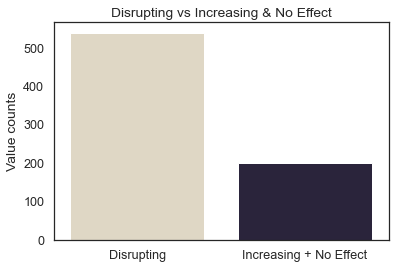

In [6]:
visualize_label_counts(predator.data_materials["train_data_processed"])
display_label_counts(predator.data_materials["train_data_processed"])

## Data Sampling with Unique Proteins

In [7]:
predator.sample_spsm()

2021-10-09 18:14:30 | DEBUG    | Predator | sampling ..


  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
predator.data_materials.keys()

dict_keys(['train_data', 'train_data_processed', 'sampled_train_data_list'])

In [9]:
display_data(predator.data_materials["sampled_train_data_list"][0], head_row=5)

Data dimensions: (164, 62)


,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,Q9BPZ3,F118A,P11940,1.0000,1.000000,1.0000,0.968750,1.219700,-0.092273,...,118.0,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293
1,0,P01116,Y40C,P50749,0.9277,0.931315,0.3553,0.172500,2.076950,0.998749,...,329.0,47.61770,47.21160,70.2902,70.2461,464.470,400.030,864.505,3.07827,3.59123
2,0,Q96QK1,T629D,Q9UBQ0-2,1.0000,0.360743,1.0000,0.973118,1.252190,0.403159,...,453.0,68.34290,68.21480,59.2629,59.2629,510.690,298.820,809.510,4.36339,4.34314
3,0,O43521-3,G66E,P10415-2,1.0000,0.714286,0.6505,0.435452,1.866070,-0.076393,...,181.0,2.15789,3.50531,30.7415,30.7626,421.875,272.215,694.090,3.41921,1.76365
4,1,Q13418,Q362H,Q9NVD7,0.9925,0.971054,1.0000,0.961240,0.621791,0.206189,...,391.0,60.07690,60.06430,33.8017,33.8017,406.135,174.195,580.330,3.39874,3.39874


In [10]:
# Number of sampled train data
len(predator.data_materials["sampled_train_data_list"])

50

### Label Distributions in Training Data

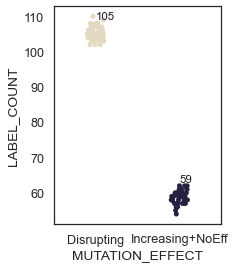

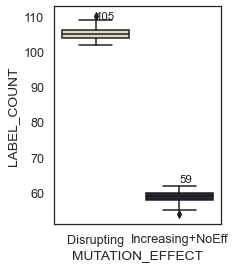

In [11]:
visualize_sampled_train_datasets_label_counts(predator.data_materials["sampled_train_data_list"], kind='strip')
visualize_sampled_train_datasets_label_counts(predator.data_materials["sampled_train_data_list"], kind='box')

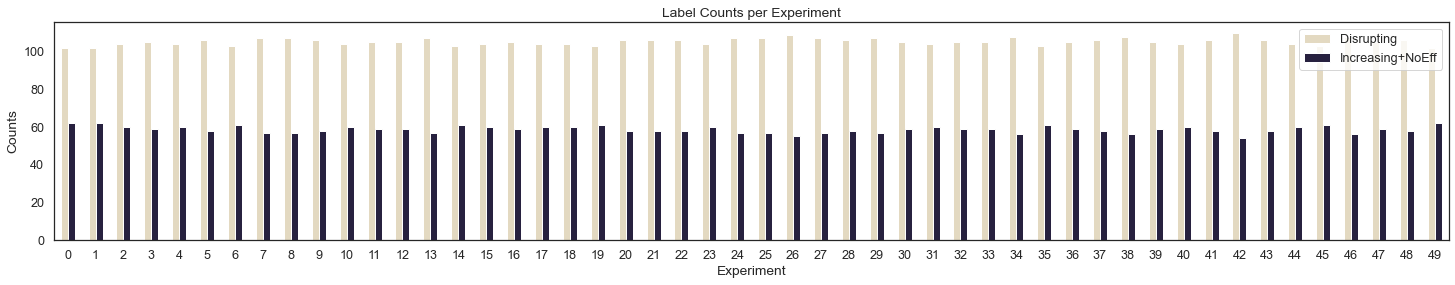

In [12]:
visualize_sampled_train_datasets_label_counts(predator.data_materials["sampled_train_data_list"], kind='bar')

## Preparing the Train Data Materials for Machine Learning Algorithms

In [13]:
predator.data_materials.keys()

dict_keys(['train_data', 'train_data_processed', 'sampled_train_data_list'])

In [14]:
predator.data_materials.prepare_model_data_materials()  # it will initialize Xs etc. too

2021-10-09 18:14:46 | DEBUG    | helpers.helpers_predator.data_materials | preparing datasets for ML ..
2021-10-09 18:14:46 | DEBUG    | helpers.helpers_predator.data_materials | Initializing model datasets ..


  0%|          | 0/50 [00:00<?, ?it/s]

2021-10-09 18:14:46 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-10-09 18:14:46 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-10-09 18:14:46 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-10-09 18:14:46 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-10-09 18:14:46 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-10-09 18:14:46 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-10-09 18:14:46 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-10-09 18:14:46 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-10-09 18:14:46 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-10-09 18:14:46 | DEBUG    | helpers.helpers_predator.data_materials 

In [15]:
print(len(predator.data_materials["Xs"]))
predator.data_materials["Xs"][0].head()

50


,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,Provean_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,1.0000,0.483871,0.9930,0.863124,5.977720,-0.103788,0.841449,1.551375,-0.805142,-8.790,...,316.0,8.64833,8.63232,90.3947,89.1921,524.985,258.980,783.96,2.46202,2.98422
1,1.0000,1.000000,0.4167,0.372027,1.700660,-0.116186,0.028181,-0.446740,0.127684,-7.998,...,249.0,27.72640,27.86500,139.5970,139.5970,386.025,245.065,631.09,3.57046,3.48332
2,0.6803,0.517968,0.4645,0.481888,0.937272,0.058100,0.165439,-0.028320,1.569780,-3.628,...,318.0,293.43500,294.70400,45.8003,45.8003,716.790,358.840,1075.62,4.33509,4.33509
3,0.9945,0.975130,0.9939,0.906319,1.511710,0.994536,0.171553,1.875893,-0.410594,-6.333,...,712.0,200.85600,199.44300,62.1484,62.1484,267.500,155.585,423.08,3.07379,3.07379
4,0.9032,0.902219,0.8519,0.838599,1.414480,0.156140,0.500075,1.100519,0.299283,-5.300,...,236.0,49.67150,48.43100,23.9715,23.9715,176.945,115.630,292.58,2.94553,5.48003


## Initial Insights

For each experiment, the models are fitted with 80% of training data and predictions are made for the remaining 20%. Then performance is evaluated comparing predictions with groundtruth labels.

In [16]:
predator.run_evaluate_valid(models_type='default')

2021-10-09 18:14:48 | DEBUG    | helpers.helpers_predator.evaluation | Training on train set and measuring performance by predicting on validation set.
2021-10-09 18:14:48 | DEBUG    | helpers.helpers_predator.evaluation | Evaluating with default models.


  0%|          | 0/50 [00:00<?, ?it/s]

-------- EXPERIMENT:  1 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.shape=(33, 58), y_valid.shape=(33,)
Classifier: RandomForestClassifier(random_state=42)
Accuracy score		: 0.6667
Balanced accuracy score : 0.5952
-------- EXPERIMENT:  2 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.shape=(33, 58), y_valid.shape=(33,)
Classifier: RandomForestClassifier(random_state=42)
Accuracy score		: 0.6970
Balanced accuracy score : 0.6190
-------- EXPERIMENT:  3 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.shape=(33, 58), y_valid.shape=(33,)
Classifier: RandomForestClassifier(random_state=42)
Accuracy score		: 0.6970
Balanced accuracy score : 0.6548
-------- EXPERIMENT:  4 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.shape=(33, 58), y_valid.shape=(33,)
Classifier: RandomForestClassifier(random_state=42)
Accuracy score		: 0.6970
Balanced accuracy score : 0.6012
-------- EXPERIMENT:  5 --------
X_train.shape=(131, 58), y_trai

In [17]:
from helpers.helpers_predator.visualizers import visualize_accuracy_metrics

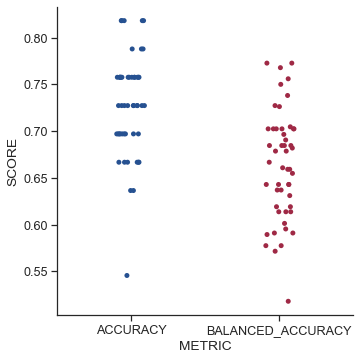

In [18]:
visualize_accuracy_metrics(
    predator.eval_valid.scores["initial_scoring"]["acc_scores"], 
    predator.eval_valid.scores["initial_scoring"]["balan_acc_scores"],
    kind='strip'
)

## SHAP Feature Importance Ranking

In [19]:
# shap_top_ns = [10, 20]
shap_top_ns = [5, 10, 20, 30, 40]

In [20]:
predator.init_shap_feature_selector(shap_top_ns)

2021-10-09 18:15:00 | DEBUG    | helpers.helpers_predator.feature_selection | Initializing ShapFeatureSelector ..


2021-10-09 18:15:00 | DEBUG    | helpers.helpers_predator.feature_selection | Loading ShapFeatureSelector ..


  0%|          | 0/50 [00:00<?, ?it/s]

 === SELECTED FEATURES === 
 --- SHAP TOP 5 ---
Experiment 1
['Provean_score', 'EL2_score', 'Matrix_score', 'electrostatics_mut', 'Final_ddG']

Experiment 2
['Provean_score', 'EL2_score', 'Final_ddG', 'solvation_polar_wt', 'entropy_mainchain_wt']

Experiment 3
['EL2_score', 'Final_ddG', 'Provean_score', 'Interface_contact_distance_mut', 'Interface_contact_distance_wt']

Experiment 4
['EL2_score', 'Provean_score', 'Final_ddG', 'Interface_contact_distance_mut', 'entropy_sidechain_mut']

Experiment 5
['EL2_score', 'Provean_score', 'Final_ddG', 'sidechain_hbond_mut', 'Solvent_accessibility_wt']

Experiment 6
['Final_ddG', 'EL2_score', 'Provean_score', 'solvation_polar_mut', 'solvation_polar_wt']

Experiment 7
['EL2_score', 'Provean_score', 'Final_ddG', 'Matrix_score', 'electrostatics_mut']

Experiment 8
['EL2_score', 'Provean_score', 'Final_ddG', 'Solvent_accessibility_mut', 'pcv_vdW_self_wt']

Experiment 9
['Provean_score', 'EL2_score', 'Final_ddG', 'Matrix_score', 'ProteinSolver_score']


## Aggregated Feature Selection

In [21]:
predator.aggregate_selected_features('occurrence')

2021-10-09 18:15:13 | DEBUG    | helpers.helpers_predator.data_materials | Initialize feature selected data materials [n_top=5]..
2021-10-09 18:15:13 | DEBUG    | helpers.helpers_predator.data_materials | Initialize feature selected data materials [n_top=10]..
2021-10-09 18:15:13 | DEBUG    | helpers.helpers_predator.data_materials | Initialize feature selected data materials [n_top=20]..
2021-10-09 18:15:13 | DEBUG    | helpers.helpers_predator.data_materials | Initialize feature selected data materials [n_top=30]..
2021-10-09 18:15:14 | DEBUG    | helpers.helpers_predator.data_materials | Initialize feature selected data materials [n_top=40]..


In [22]:
predator.shap_feature_selector.aggregated_feature_selector.n_features_to_selected_features_occurrences_counts

defaultdict(dict,
            {5: defaultdict(int,
                         {'Provean_score': 49,
                          'EL2_score': 50,
                          'Matrix_score': 22,
                          'electrostatics_mut': 2,
                          'Final_ddG': 46,
                          'solvation_polar_wt': 4,
                          'entropy_mainchain_wt': 3,
                          'Interface_contact_distance_mut': 5,
                          'Interface_contact_distance_wt': 1,
                          'entropy_sidechain_mut': 1,
                          'sidechain_hbond_mut': 1,
                          'Solvent_accessibility_wt': 8,
                          'solvation_polar_mut': 3,
                          'Solvent_accessibility_mut': 9,
                          'pcv_vdW_self_wt': 1,
                          'ProteinSolver_score': 2,
                          'Interactor_alignment_score': 22,
                          'entropy_sidechain_wt': 3,
    

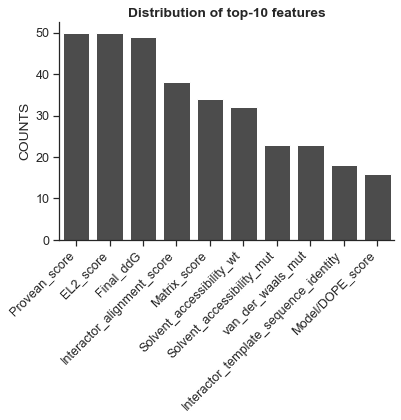

In [23]:
from helpers.helpers_predator.visualizers import visualize_distribution_top_n_features

visualize_distribution_top_n_features(predator.shap_feature_selector, 10)  # available for each shap_top_ns.

In [24]:
predator.shap_feature_selector.n_features_to_aggregated_features[10]

['Provean_score',
 'EL2_score',
 'Final_ddG',
 'Interactor_alignment_score',
 'Matrix_score',
 'Solvent_accessibility_wt',
 'Solvent_accessibility_mut',
 'van_der_waals_mut',
 'Interactor_template_sequence_identity',
 'Model/DOPE_score']

In [25]:
predator.shap_feature_selector.display_rankings(10, extract=True)

2021-10-09 18:15:15 | DEBUG    | helpers.helpers_predator.feature_selection | Displaying rankings ..
2021-10-09 18:15:15 | DEBUG    | helpers.helpers_predator.feature_selection | Extracting rankings ..
2021-10-09 18:15:15 | INFO     | helpers.helpers_predator.feature_selection | Rankings are extracted to file rankings_10.csv.


,0,1,2,3,4,5,6,7,8,9
0,Provean_score,EL2_score,Matrix_score,electrostatics_mut,Final_ddG,Interactor_alignment_score,Solvent_accessibility_mut,Model/DOPE_score,van_der_waals_mut,pcv_vdW_self_wt
1,Provean_score,EL2_score,Final_ddG,solvation_polar_wt,entropy_mainchain_wt,sidechain_hbond_mut,Solvent_accessibility_mut,Solvent_accessibility_wt,van_der_waals_mut,Model/DOPE_score
2,EL2_score,Final_ddG,Provean_score,Interface_contact_distance_mut,Interface_contact_distance_wt,entropy_sidechain_wt,Solvent_accessibility_mut,entropy_sidechain_mut,pcv_vdW_wt,Interactor_alignment_score
3,EL2_score,Provean_score,Final_ddG,Interface_contact_distance_mut,entropy_sidechain_mut,Interactor_template_sequence_identity,van_der_waals_mut,Interface_contact_distance_wt,sidechain_hbond_wt,Model/DOPE_score
4,EL2_score,Provean_score,Final_ddG,sidechain_hbond_mut,Solvent_accessibility_wt,Matrix_score,entropy_sidechain_mut,entropy_sidechain_wt,sidechain_hbond_wt,Interactor_template_sequence_identity


In [26]:
predator.shap_feature_selector.n_features_to_aggregated_features

{5: ['EL2_score',
  'Provean_score',
  'Final_ddG',
  'Matrix_score',
  'Interactor_alignment_score'],
 10: ['Provean_score',
  'EL2_score',
  'Final_ddG',
  'Interactor_alignment_score',
  'Matrix_score',
  'Solvent_accessibility_wt',
  'Solvent_accessibility_mut',
  'van_der_waals_mut',
  'Interactor_template_sequence_identity',
  'Model/DOPE_score'],
 20: ['Provean_score',
  'EL2_score',
  'Final_ddG',
  'Interactor_alignment_score',
  'van_der_waals_mut',
  'Matrix_score',
  'Solvent_accessibility_wt',
  'Solvent_accessibility_mut',
  'Interactor_template_sequence_identity',
  'Model/DOPE_score',
  'entropy_sidechain_mut',
  'electrostatics_mut',
  'ProteinSolver_score',
  'ProtBert_score',
  'solvation_polar_wt',
  'entropy_mainchain_wt',
  'solvation_polar_mut',
  'entropy_sidechain_wt',
  'pcv_vdW_self_wt',
  'Interface_contact_distance_mut'],
 30: ['Provean_score',
  'EL2_score',
  'Final_ddG',
  'Interactor_alignment_score',
  'van_der_waals_mut',
  'Solvent_accessibility_wt',

In [27]:
predator.shap_feature_selector.n_features_to_aggregated_features[10]

['Provean_score',
 'EL2_score',
 'Final_ddG',
 'Interactor_alignment_score',
 'Matrix_score',
 'Solvent_accessibility_wt',
 'Solvent_accessibility_mut',
 'van_der_waals_mut',
 'Interactor_template_sequence_identity',
 'Model/DOPE_score']

## Evaluation Metrics

In [28]:
from helpers.helpers_predator.evaluation import evaluate_metrics

In [29]:
predator.initialize_evaluation_metrics()

2021-10-09 18:15:15 | INFO     | helpers.helpers_predator.evaluation | Initializing EvaluationMetrics..
2021-10-09 18:15:15 | INFO     | helpers.helpers_predator.evaluation | Initialize_benchmark_dataframes ..


<div class="alert alert-block" style="background-color: white; border: 2px solid; padding: 10px; border-color: #F57C00">
    <b style="color: #F57C00"><i class="fa fa-warning" aria-hidden="true"></i>&nbsp; Warning</b><br>
<div>
    
Evaluation will take a long time.

In [ ]:
raise

In [30]:
predator.eval_metrics.run_eval_metrics(n_repeats=1, n_jobs=5, verbose=True)
# todo
# predator.run_evaluation_metrics(n_repeats=5, n_jobs=4, verbose=True)

2021-10-09 18:15:41 | INFO     | helpers.helpers_predator.evaluation | Running evaluation metrics ..


  0%|          | 0/50 [00:00<?, ?it/s]


EVALUATION METRIC: F1
------------------------------------
X_train_exp_0_provean       : 0.4763
X_train_exp_0_ddG           : 0.4847
X_train_exp_0               : 0.6111
X_train_exp_0_shap_5        : 0.5115
X_train_exp_0_shap_10       : 0.5517
X_train_exp_0_shap_20       : 0.5294
X_train_exp_0_shap_30       : 0.5994
X_train_exp_0_shap_40       : 0.5802

EVALUATION METRIC: BALANCED_ACCURACY
------------------------------------
X_train_exp_0_provean       : 0.6451
X_train_exp_0_ddG           : 0.5882
X_train_exp_0               : 0.6076
X_train_exp_0_shap_5        : 0.6176
X_train_exp_0_shap_10       : 0.6625
X_train_exp_0_shap_20       : 0.7019
X_train_exp_0_shap_30       : 0.6819
X_train_exp_0_shap_40       : 0.7064

EVALUATION METRIC: ACCURACY
------------------------------------
X_train_exp_0_provean       : 0.6797
X_train_exp_0_ddG           : 0.572
X_train_exp_0               : 0.6797
X_train_exp_0_shap_5        : 0.6956
X_train_exp_0_shap_10       : 0.7407
X_train_exp_0_shap_20  

In [31]:
predator.eval_metrics.scoring_metrics_data

,Provean,$\Delta\Delta$G,All Columns,SHAP Columns (5),SHAP Columns (10),SHAP Columns (20),SHAP Columns (30),SHAP Columns (40)
METRIC,,,,,,,,
accuracy,0.608608,0.593184,0.708554,0.718434,0.731824,0.732954,0.721760,0.721516
balanced_accuracy,0.584584,0.558856,0.649188,0.664852,0.682868,0.678764,0.665382,0.662216
f1,0.460978,0.408260,0.499036,0.529504,0.552406,0.540436,0.520012,0.506262
f1_macro,0.575592,0.550896,0.638540,0.660010,0.682670,0.677280,0.660832,0.652216
f1_micro,0.610918,0.592438,0.714802,0.708570,0.733240,0.734074,0.723942,0.721238
precision,0.467904,0.440274,0.664276,0.646692,0.690770,0.689324,0.677932,0.692092
precision_macro,0.585990,0.557632,0.709276,0.706228,0.725778,0.729258,0.718124,0.709596
precision_micro,0.611756,0.592080,0.719038,0.713898,0.729724,0.733362,0.727814,0.717522
recall,0.482200,0.433100,0.415500,0.497500,0.503700,0.480800,0.465600,0.437800


|                   |  Provean |      $\Delta\Delta$G | All Columns | SHAP Columns (5) | SHAP Columns (10) | SHAP Columns (20) | SHAP Columns (30) | SHAP Columns (40) |
|------------------:|---------:|---------:|------------:|-----------------:|------------------:|------------------:|------------------:|------------------:|
|          **accuracy** | 0.610760 | 0.593208 |    0.714452 |         0.709600 |          0.731082 |          0.730880 |          0.723732 |          0.721166 |
| **balanced_accuracy** | 0.581348 | 0.553346 |    0.646770 |         0.658926 |          0.684346 |          0.680468 |          0.667830 |          0.660290 |
|                **f1** | 0.457686 | 0.419508 |    0.488514 |         0.524742 |          0.548794 |          0.547668 |          0.527700 |          0.505250 |
|          **f1_macro** | 0.571148 | 0.546018 |    0.636866 |         0.660598 |          0.679270 |          0.676998 |          0.659292 |          0.654624 |
|          **f1_micro** | 0.614980 | 0.589080 |    0.711412 |         0.717540 |          0.732424 |          0.733220 |          0.726720 |          0.721122 |
|         **precision** | 0.474758 | 0.432868 |    0.671394 |         0.652346 |          0.688832 |          0.693074 |          0.673812 |          0.669226 |
|   **precision_macro** | 0.595020 | 0.560870 |    0.696782 |         0.703838 |          0.721984 |          0.737650 |          0.722108 |          0.710566 |
|   **precision_micro** | 0.612284 | 0.595524 |    0.713366 |         0.715992 |          0.734674 |          0.735460 |          0.726382 |          0.720640 |
|            **recall** | 0.479600 | 0.428800 |    0.414700 |         0.494300 |          0.506600 |          0.485700 |          0.469800 |          0.429400 |
|           **roc_auc** | 0.636772 | 0.609460 |    0.738156 |         0.745736 |          0.763738 |          0.762828 |          0.758032 |          0.752386 |

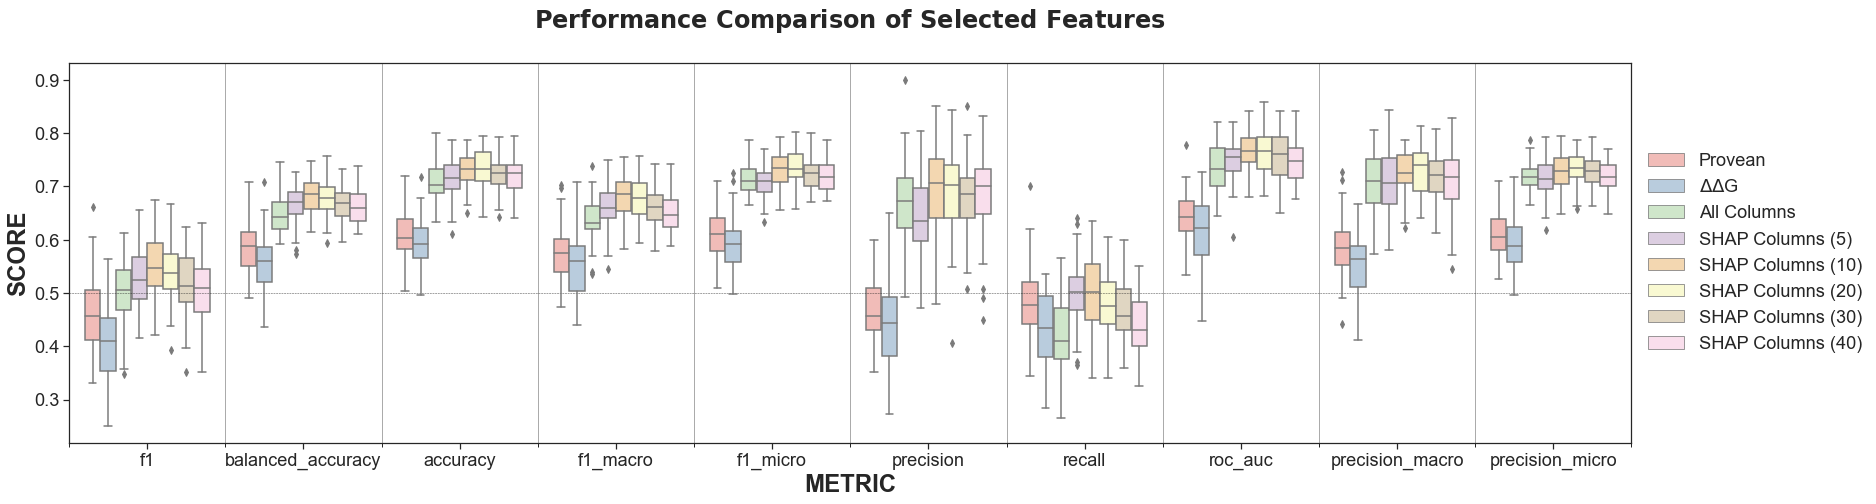

In [32]:
predator.eval_metrics.plot_performance_comparison_results()

## Fine Tuning

Fine Tuning on 80% of data (training *set*)

In [33]:
determined_feature_set = "shap_10"
predator.set_determined_feature_set(determined_feature_set)

2021-10-09 19:15:17 | DEBUG    | Predator | Setting determined feature set to `shap_10`.
2021-10-09 19:15:17 | DEBUG    | Predator | Setting determined features to 
['Provean_score', 'EL2_score', 'Final_ddG', 'Interactor_alignment_score', 'Matrix_score', 'Solvent_accessibility_wt', 'Solvent_accessibility_mut', 'van_der_waals_mut', 'Interactor_template_sequence_identity', 'Model/DOPE_score'].


In [34]:
predator.run_hyperparameter_search(
    n_iter=1,
    n_repeats_cv=1,
    n_jobs=4,
    verbose=0,
    search_type="randomized",
    param_grid_level=0
)

2021-10-09 19:15:20 | DEBUG    | helpers.helpers_predator.fine_tuning | Running randomized search for each experiment ..
2021-10-09 19:15:20 | DEBUG    | helpers.helpers_predator.fine_tuning | PARAM_GRID: {'max_depth': [2, 5, 10], 'n_estimators': [10, 25, 50, 75, 100, 200, 400], 'min_samples_split': [2, 5], 'max_features': ['auto', 'sqrt', None], 'class_weight': ['balanced', None]}


  0%|          | 0/50 [00:00<?, ?it/s]

In [35]:
predator.fine_tuner.classifiers_attributes_data.head()

,best_params_,best_estimator_,best_score_
EXP_1,"{'n_estimators': 50, 'min_samples_split': 5, '...","(DecisionTreeClassifier(max_depth=2, min_sampl...",0.677083
EXP_2,"{'n_estimators': 10, 'min_samples_split': 2, '...","(DecisionTreeClassifier(max_depth=5, max_featu...",0.665694
EXP_3,"{'n_estimators': 25, 'min_samples_split': 5, '...","(DecisionTreeClassifier(max_depth=10, max_feat...",0.704028
EXP_4,"{'n_estimators': 75, 'min_samples_split': 5, '...","(DecisionTreeClassifier(max_depth=10, min_samp...",0.631111
EXP_5,"{'n_estimators': 25, 'min_samples_split': 2, '...","(DecisionTreeClassifier(max_depth=10, max_feat...",0.688472


In [36]:
predator.fine_tuner.best_estimators[:5]

[RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=None,
                        min_samples_split=5, n_estimators=50, random_state=1),
 RandomForestClassifier(max_depth=5, n_estimators=10, random_state=2),
 RandomForestClassifier(class_weight='balanced', max_depth=10,
                        max_features='sqrt', min_samples_split=5,
                        n_estimators=25, random_state=3),
 RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=None,
                        min_samples_split=5, n_estimators=75, random_state=4),
 RandomForestClassifier(class_weight='balanced', max_depth=10,
                        max_features='sqrt', n_estimators=25, random_state=5)]

In [37]:
len(predator.tuned_models)

50

In [38]:
predator.tuned_models[:5]

[RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=None,
                        min_samples_split=5, n_estimators=50, random_state=1),
 RandomForestClassifier(max_depth=5, n_estimators=10, random_state=2),
 RandomForestClassifier(class_weight='balanced', max_depth=10,
                        max_features='sqrt', min_samples_split=5,
                        n_estimators=25, random_state=3),
 RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=None,
                        min_samples_split=5, n_estimators=75, random_state=4),
 RandomForestClassifier(class_weight='balanced', max_depth=10,
                        max_features='sqrt', n_estimators=25, random_state=5)]

In [39]:
predator.fine_tuner.best_estimators[:5] == predator.tuned_models[:5]

True

In [40]:
predator.default_models[0]

RandomForestClassifier(random_state=42)

In [41]:
len(predator.tuned_models)

50

In [42]:
predator.tuned_models[0]

RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=None,
                       min_samples_split=5, n_estimators=50, random_state=1)

In [43]:
predator.tuned_models[1]

RandomForestClassifier(max_depth=5, n_estimators=10, random_state=2)

## Performance of Tuned Models on (out of sample) Validation Data

For each experiment, the **hyper-tuned** models are fitted with 80% of training data and predictions are made for the remaining 20%. Then performance is evaluated comparing predictions with groundtruth labels.

In [44]:
predator.run_evaluate_valid(models_type='feature_selected')

2021-10-09 19:18:25 | DEBUG    | helpers.helpers_predator.evaluation | Training on train set and measuring performance by predicting on validation set.
2021-10-09 19:18:25 | DEBUG    | helpers.helpers_predator.evaluation | Evaluating with default models using determined features.
2021-10-09 19:18:25 | DEBUG    | helpers.helpers_predator.evaluation | Determined features: 
['Provean_score', 'EL2_score', 'Final_ddG', 'Interactor_alignment_score', 'Matrix_score', 'Solvent_accessibility_wt', 'Solvent_accessibility_mut', 'van_der_waals_mut', 'Interactor_template_sequence_identity', 'Model/DOPE_score']


  0%|          | 0/50 [00:00<?, ?it/s]

-------- EXPERIMENT:  1 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Classifier: RandomForestClassifier(random_state=42)
Accuracy score		: 0.7576
Balanced accuracy score : 0.6845
-------- EXPERIMENT:  2 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Classifier: RandomForestClassifier(random_state=42)
Accuracy score		: 0.7273
Balanced accuracy score : 0.6607
-------- EXPERIMENT:  3 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Classifier: RandomForestClassifier(random_state=42)
Accuracy score		: 0.8485
Balanced accuracy score : 0.7917
-------- EXPERIMENT:  4 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Classifier: RandomForestClassifier(random_state=42)
Accuracy score		: 0.7576
Balanced accuracy score : 0.7024
-------- EXPERIMENT:  5 --------
X_train.shape=(131, 10), y_trai

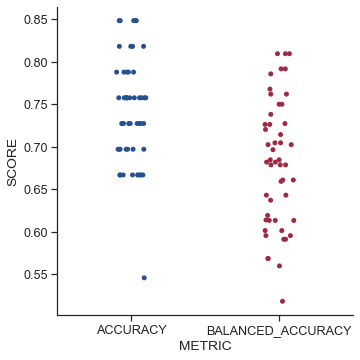

In [45]:
visualize_accuracy_metrics(
    predator.eval_valid.scores["feature_selected_scoring"]["acc_scores"], 
    predator.eval_valid.scores["feature_selected_scoring"]["balan_acc_scores"],
    kind='strip'
)

In [46]:
predator.run_evaluate_valid(models_type='tuned')

2021-10-09 19:18:42 | DEBUG    | helpers.helpers_predator.evaluation | Training on train set and measuring performance by predicting on validation set.
2021-10-09 19:18:42 | DEBUG    | helpers.helpers_predator.evaluation | Evaluating with tuned models.
2021-10-09 19:18:42 | DEBUG    | helpers.helpers_predator.evaluation | Determined features: 
['Provean_score', 'EL2_score', 'Final_ddG', 'Interactor_alignment_score', 'Matrix_score', 'Solvent_accessibility_wt', 'Solvent_accessibility_mut', 'van_der_waals_mut', 'Interactor_template_sequence_identity', 'Model/DOPE_score']


  0%|          | 0/50 [00:00<?, ?it/s]

-------- EXPERIMENT:  1 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Classifier: RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=None,
                       min_samples_split=5, n_estimators=50, random_state=1)
Accuracy score		: 0.7576
Balanced accuracy score : 0.7024
-------- EXPERIMENT:  2 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Classifier: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=2)
Accuracy score		: 0.6970
Balanced accuracy score : 0.6726
-------- EXPERIMENT:  3 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Classifier: RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='sqrt', min_samples_split=5,
                       n_estimators=25, random_state=3)
Accuracy score		: 0.7576
Balanced accuracy score : 0.7202
-------- 

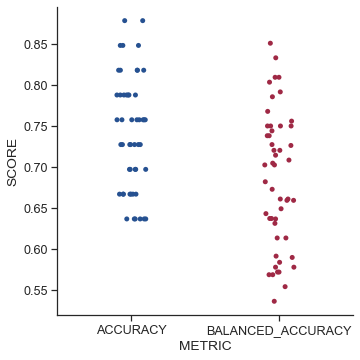

In [47]:
visualize_accuracy_metrics(
    predator.eval_valid.scores["finalized_scoring"]["acc_scores"], 
    predator.eval_valid.scores["finalized_scoring"]["balan_acc_scores"],
    kind='strip'
)

,Experiment,Acc_scores,Balan_acc_scores,Models_type
0,0,0.757576,0.702381,Tuned+FeatureSelected
1,1,0.696970,0.672619,Tuned+FeatureSelected
2,2,0.757576,0.720238,Tuned+FeatureSelected
3,3,0.878788,0.833333,Tuned+FeatureSelected
4,4,0.787879,0.726190,Tuned+FeatureSelected
5,5,0.787879,0.708333,Tuned+FeatureSelected
6,6,0.818182,0.750000,Tuned+FeatureSelected
7,7,0.787879,0.704545,Tuned+FeatureSelected
8,8,0.636364,0.568182,Tuned+FeatureSelected
9,9,0.727273,0.714286,Tuned+FeatureSelected


       Experiment  Acc_scores  Balan_acc_scores
count    50.00000   50.000000         50.000000
mean     24.50000    0.740606          0.683885
std      14.57738    0.069307          0.082390
min       0.00000    0.636364          0.535714
25%      12.25000    0.674242          0.617560
50%      24.50000    0.742424          0.692100
75%      36.75000    0.787879          0.748512
max      49.00000    0.878788          0.851190
2021-10-09 19:19:07 | INFO     | helpers.helpers_predator.evaluation | balanced_acc_threshold: 0.6175595238095238
2021-10-09 19:19:07 | INFO     | helpers.helpers_predator.evaluation | bad_models_ix: [8, 10, 13, 14, 15, 18, 33, 37, 40, 41, 44, 46, 48]
2021-10-09 19:19:07 | INFO     | helpers.helpers_predator.evaluation | qualified_models_ix: [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 42, 43, 45, 47, 49]
                                 Number of Model
Tuned+FeatureSelected              

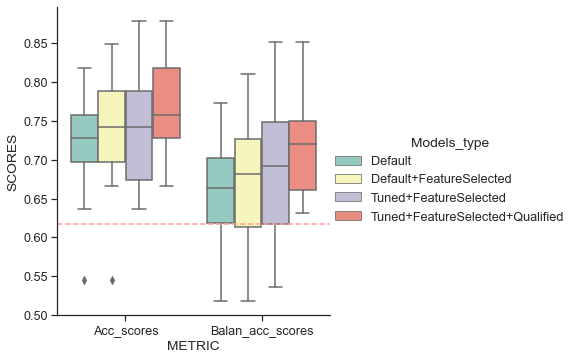

In [48]:
predator.compare_tuned_models(kind='box')

In [49]:
predator.eval_valid.comparison_data

Models_type,Default,Default+FeatureSelected,Tuned+FeatureSelected,Tuned+FeatureSelected+Qualified
Acc_scores,0.728485,0.741818,0.740606,0.769861
Balan_acc_scores,0.663214,0.679675,0.683885,0.721116


In [50]:
print(len(predator.default_models))
pprint(predator.default_models[:3])
print(' - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  ')
print(len(predator.tuned_models))
pprint(predator.tuned_models[:3])
print(' - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  ')
print(len(predator.qualified_models))
pprint(predator.qualified_models[:3])

50
[RandomForestClassifier(random_state=42),
 RandomForestClassifier(random_state=42),
 RandomForestClassifier(random_state=42)]
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
50
[RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=None,
                       min_samples_split=5, n_estimators=50, random_state=1),
 RandomForestClassifier(max_depth=5, n_estimators=10, random_state=2),
 RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='sqrt', min_samples_split=5,
                       n_estimators=25, random_state=3)]
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
37
[RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=None,
                       min_samples_split=5, n_estimators=50, random_state=1),
 RandomForestClassifier(max_depth=5, n_estimators=10, random_state=2),
 RandomForestClassifier(class_weight='balanced', m

In [51]:
print(len(predator.qualified_models))
predator.qualified_models == predator.eval_valid.qualified_models

37


True

## Fit Finalized Models

For each experiment, the **hyper-tuned** models are fitted with **all of training** data. These models then will be used to make prediction on TCGA Cancer Datasets.

In [52]:
predator.fit_finalized_models()

2021-10-09 19:19:39 | DEBUG    | Predator | Fitting finalized models with all training data ..
2021-10-09 19:19:39 | INFO     | Predator | Model elimination: True
2021-10-09 19:19:39 | INFO     | Predator | Using 37 qualified models as finalized models.


  0%|          | 0/37 [00:00<?, ?it/s]

In [53]:
print(predator.n_experiment)
print(predator.n_models)

50
37


In [54]:
predator.data_materials.keys()

dict_keys(['train_data', 'train_data_processed', 'sampled_train_data_list', 'prepared_dataframes', 'label_proportions_dataframes', 'Xs', 'ys', 'Xs_train', 'ys_train', 'Xs_valid', 'ys_valid', 'Xs_train_random', 'ys_train_random', 'Xs_valid_random', 'ys_valid_random', 'Xs_shap_5', 'Xs_train_shap_5', 'Xs_valid_shap_5', 'Xs_provean', 'Xs_train_provean', 'Xs_ddG', 'Xs_train_ddG', 'Xs_shap_10', 'Xs_train_shap_10', 'Xs_valid_shap_10', 'Xs_shap_20', 'Xs_train_shap_20', 'Xs_valid_shap_20', 'Xs_shap_30', 'Xs_train_shap_30', 'Xs_valid_shap_30', 'Xs_shap_40', 'Xs_train_shap_40', 'Xs_valid_shap_40'])

In [55]:
predator.data_materials["prepared_dataframes"][0]

,Mutation_Effect_Label,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,1.0000,0.483871,0.9930,0.863124,5.977720,-0.103788,0.841449,1.551375,-0.805142,...,316.0,8.64833,8.63232,90.3947,89.1921,524.985,258.980,783.960,2.46202,2.98422
1,1,1.0000,1.000000,0.4167,0.372027,1.700660,-0.116186,0.028181,-0.446740,0.127684,...,249.0,27.72640,27.86500,139.5970,139.5970,386.025,245.065,631.090,3.57046,3.48332
2,1,0.6803,0.517968,0.4645,0.481888,0.937272,0.058100,0.165439,-0.028320,1.569780,...,318.0,293.43500,294.70400,45.8003,45.8003,716.790,358.840,1075.620,4.33509,4.33509
3,0,0.9945,0.975130,0.9939,0.906319,1.511710,0.994536,0.171553,1.875893,-0.410594,...,712.0,200.85600,199.44300,62.1484,62.1484,267.500,155.585,423.080,3.07379,3.07379
4,0,0.9032,0.902219,0.8519,0.838599,1.414480,0.156140,0.500075,1.100519,0.299283,...,236.0,49.67150,48.43100,23.9715,23.9715,176.945,115.630,292.580,2.94553,5.48003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,0,0.9649,0.895924,1.0000,0.853448,6.019480,0.448406,0.852855,1.289853,-1.396530,...,213.0,24.48990,23.61710,24.3208,24.3748,199.225,195.180,394.405,2.61358,3.02581
160,1,0.2601,0.220524,0.7859,0.750034,0.674163,0.998012,0.138668,2.164430,-0.039903,...,591.0,193.38600,193.37800,96.4308,96.4308,380.470,208.870,589.335,6.87030,5.31362
161,0,0.3595,0.302542,0.7278,0.669387,-0.321962,0.990991,-0.005588,2.037026,-0.631221,...,369.0,58.69220,58.53710,264.5140,264.4910,637.520,335.095,972.620,3.35756,3.07060
162,0,1.0000,0.640000,1.0000,0.987179,2.224760,-0.018164,0.485696,1.558048,-1.506710,...,170.0,1.78315,1.75543,31.0296,31.0296,194.670,160.885,355.555,2.69611,2.69611


#### Predictions Post Processing

Post processing of predictions involves following steps:

##### 1. Merging Predictions with SNV Data

The prediction column is merged with SNV data for each experiment.

$\text{For each experiment } n: $

$$
  \textit{(Prediction Merged Data)}_n = \underbrace{[\textit{Predictions}_n]}_\text{0, 1 or "NoVote"} + 
      \underbrace{[\textit{Protein }] [\textit{Mutation }] [\textit{Interactor }]}_\text{Cancer Data Triplets} + \underbrace{[\textit{Features }] }_\text{Elaspic}
$$


##### 2. Convert to 1-isomer: `Interactor_UniProt_ID`

$\textit{Interactor_UniProt_ID}$ column contains isomer proteins. Here, we convert them into primary isoform representation (i.e. without dashes).

| Interactor_UniProt_ID |
--------------
| P38936     |
| P16473     |
| P16473-2   |
| P19793     |

##### 3. Dropping Invalid Predictions

Entries which predicted as both `Decreasing` and `Increasing+NoEff` are dropped.

Due to having different features for the same $\textit{(protein, mutation, interactor)}$ triplet from ELASPIC, the triplet $\textit{(protein, mutation, interactor)}$ may be classified both 0 and 1. We drop such instances.

In [65]:
predator.predictions_post_process()

2021-09-28 01:02:23 | DEBUG    | helpers.helpers_predator.predictions | PredictionsHard
2021-09-28 01:02:23 | DEBUG    | helpers.helpers_predator.predictions | Post processing predictions for cohort brca ..
2021-09-28 01:02:23 | DEBUG    | helpers.helpers_predator.predictions | Merging predictions with brca cancer dataset ..
2021-09-28 01:02:23 | DEBUG    | helpers.helpers_predator.predictions | Handling valid and invalid entries ..


  0%|          | 0/37 [00:00<?, ?it/s]

2021-09-28 01:02:43 | DEBUG    | helpers.helpers_predator.predictions_utils | Removed entries first five rows (of 466): 
   PREDICTION PROTEIN MUTATION INTERACTOR
0           1  Q9UBN7    D567Y     Q96DB2
1           0  Q9UBN7    D567Y     Q96DB2
2           0  Q15413   G2795S     Q92736
3           0  Q15413   G2795S     Q92736
4           0  Q15413   G2795S     Q92736
2021-09-28 01:03:03 | DEBUG    | helpers.helpers_predator.predictions_utils | Removed entries first five rows (of 1082): 
   PREDICTION PROTEIN MUTATION INTERACTOR
0           0  P04637    R280K     Q13625
1           1  P04637    R280K     Q13625
2           1  P04637    R280K     Q13625
3           0  P04637    R280K     P62993
4           0  P04637    R280K     P62993
2021-09-28 01:03:22 | DEBUG    | helpers.helpers_predator.predictions_utils | Removed entries first five rows (of 1229): 
   PREDICTION PROTEIN MUTATION INTERACTOR
0           1  Q9Y616    F419L     Q16288
1           0  Q9Y616    F419L     Q16288
2    

In [66]:
predator.predictions.keys()

dict_keys(['brca', 'brca_predicted_datasets', 'brca_predicted_valid_datasets', 'brca_predicted_invalid_datasets', 'brca_finalized_prediction_dataframes'])

In [67]:
predator.predictions["brca_predicted_datasets"][0].head(3)

,Prediction,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,P28062,P28062,R216W,done,interface,COSM451277,-,-,Proteasome,...,417.0,156.750,156.868,49.1868,49.1868,566.065,367.205,933.27,5.37939,3.28969
1,1,Q15842,Q15842,E237K,done,interface,COSM430893,-,-,IRK,...,684.0,131.720,131.479,129.5260,129.5260,None,None,None,2.48410,2.92169
2,1,Q15842,Q15842,E237K,done,interface,COSM430893,-,-,IRK,...,678.0,142.706,142.107,99.1151,99.1190,None,624.35,None,2.70474,3.18529


In [68]:
predator.predictions["brca_predicted_datasets"][17].head(3)

,Prediction,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,P28062,P28062,R216W,done,interface,COSM451277,-,-,Proteasome,...,417.0,156.750,156.868,49.1868,49.1868,566.065,367.205,933.27,5.37939,3.28969
1,0,Q15842,Q15842,E237K,done,interface,COSM430893,-,-,IRK,...,684.0,131.720,131.479,129.5260,129.5260,None,None,None,2.48410,2.92169
2,0,Q15842,Q15842,E237K,done,interface,COSM430893,-,-,IRK,...,678.0,142.706,142.107,99.1151,99.1190,None,624.35,None,2.70474,3.18529


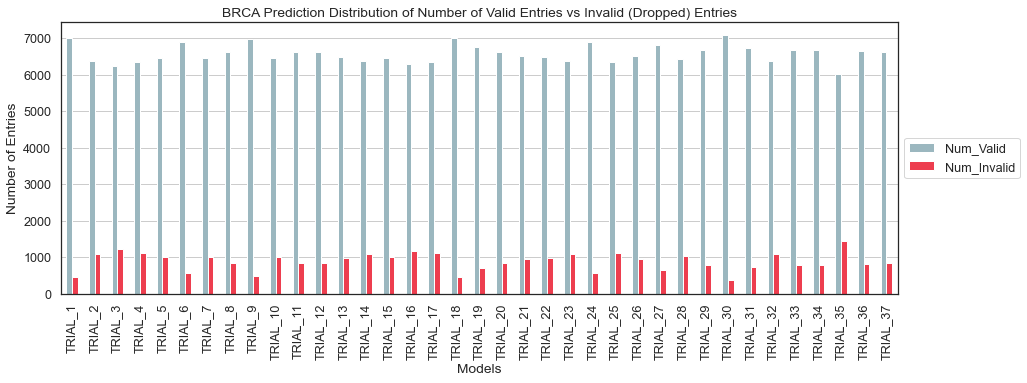

In [69]:
predator.predictions.plot_distribution_valid_vs_invalid("brca")

2021-09-28 01:14:34 | DEBUG    | helpers.helpers_predator.predictions | Plotting number of finalized predictions per model.
Note that following plot shows the unique (protein, mutation, interactor) triplets which had valid prediction.


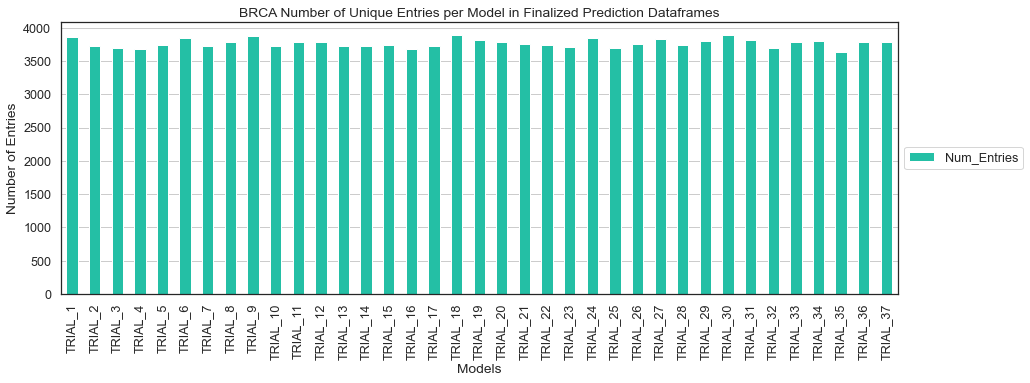

In [70]:
predator.predictions.plot_num_finalized_predictions("brca")

In [71]:
predator.prepare_ensemble_prediction_data()

2021-09-28 01:14:35 | DEBUG    | helpers.helpers_predator.predictions | PredictionsHard
2021-09-28 01:14:35 | DEBUG    | helpers.helpers_predator.predictions | Preparing ensemble prediction data for brca ..


  0%|          | 0/3985 [00:00<?, ?it/s]

2021-09-28 01:19:10 | DEBUG    | helpers.helpers_predator.predictions | Ensemble prediction data for brca is prepared.
2021-09-28 01:19:10 | DEBUG    | helpers.helpers_predator.predictions | Resulting prediction data is available for brca.
Accessible from predictions.['brca_prediction_results']
2021-09-28 01:19:10 | DEBUG    | helpers.helpers_predator.predictions | Resulting prediction data (no_votes dropped) is available for brca.
Accessible from predictions.['brca_prediction_results_no_votes_dropped']


In [72]:
predator.predictions["brca_ensemble_prediction_data"].head()

,UniProt_ID,Mutation,Interactor_UniProt_ID,Num_preds_0,Num_preds_1,Num_preds_NO_VOTE,VOTED_PREDICTION
0,P28062,R216W,P40306,24,13,0,0
1,Q15842,E237K,Q14654,21,16,0,0
2,Q15842,E237K,P63252,25,12,0,0
3,Q9UKS6,R24H,Q9BY11,31,6,0,0
4,Q9UKS6,R24H,Q9UNF0,32,2,3,0


In [73]:
print(predator.data_materials["brca"].shape)
predator.data_materials["brca"].head()

(7467, 103)


,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,Domain_clan,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,P28062,P28062,R216W,done,interface,COSM451277,-,-,Proteasome,Proteasome,...,417.0,156.7500,156.8680,49.1868,49.1868,566.065,367.205,933.27,5.37939,3.28969
1,Q15842,Q15842,E237K,done,interface,COSM430893,-,-,IRK,IRK,...,684.0,131.7200,131.4790,129.5260,129.5260,None,None,None,2.48410,2.92169
2,Q15842,Q15842,E237K,done,interface,COSM430893,-,-,IRK,IRK,...,678.0,142.7060,142.1070,99.1151,99.1190,None,624.35,None,2.70474,3.18529
3,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
4,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813


In [74]:
print(predator.data_materials["Xs_brca"][0].shape)
predator.data_materials["Xs_brca"][0].head()

(7467, 10)


,Provean_score,EL2_score,Final_ddG,Interactor_alignment_score,Matrix_score,Solvent_accessibility_wt,Solvent_accessibility_mut,van_der_waals_mut,Interactor_template_sequence_identity,Model/DOPE_score
0,-6.335,1.142869,0.789252,0.823800,-4.0,70.4880,66.3922,-22.0706,0.8858,-0.103731
1,-3.934,2.435212,2.112660,0.472829,1.0,85.3259,100.2340,-42.9531,0.4623,0.750751
2,-3.934,2.151470,2.342750,0.535672,1.0,85.2024,97.7820,-48.3449,0.5380,0.902388
3,-4.726,1.761235,0.730056,0.936088,0.0,86.9245,74.8117,-64.1391,0.9857,-1.137780
4,-4.726,1.129695,0.795178,0.993160,0.0,68.1041,64.0505,-64.9898,0.9928,-0.929739


In [75]:
predator.data_materials["Xs_brca"][0].iloc[[0]]

,Provean_score,EL2_score,Final_ddG,Interactor_alignment_score,Matrix_score,Solvent_accessibility_wt,Solvent_accessibility_mut,van_der_waals_mut,Interactor_template_sequence_identity,Model/DOPE_score
0,-6.335,1.142869,0.789252,0.8238,-4.0,70.488,66.3922,-22.0706,0.8858,-0.103731


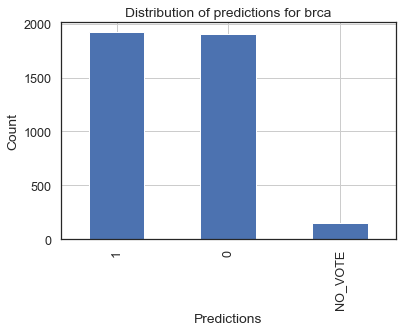

In [76]:
predator.predictions.plot_ensemble_prediction_distribution("brca")

In [77]:
brca_prediction_results_hard = predator.predictions["brca_prediction_results"]
brca_prediction_results_hard.head()

,UniProt_ID,Mutation,Interactor_UniProt_ID,Prediction
0,P28062,R216W,P40306,0
1,Q15842,E237K,Q14654,0
2,Q15842,E237K,P63252,0
3,Q9UKS6,R24H,Q9BY11,0
4,Q9UKS6,R24H,Q9UNF0,0


In [78]:
brca_prediction_results_hard_no_votes_dropped = predator.predictions["brca_prediction_results_no_votes_dropped"]

Label counts:
Disrupting                1908
Increasing + No Effect    1925
Name: Prediction, dtype: int64


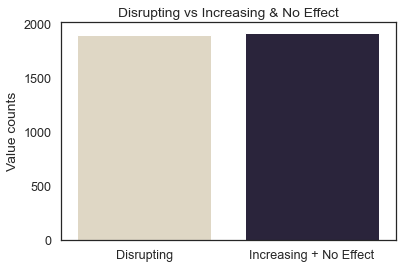

In [79]:
visualize_label_counts(brca_prediction_results_hard_no_votes_dropped, 'Prediction')

In [80]:
brca_ensemble_prediction_data_hard = predator.predictions["brca_ensemble_prediction_data"]

In [81]:
#######
hard_brca_predicted_valid_datasets = predator.predictions[f"brca_predicted_valid_datasets"]
hard_brca_predicted_invalid_datasets = predator.predictions[f"brca_predicted_invalid_datasets"]

In [82]:
predator.initialize_target_data_materials()

2021-09-28 01:19:11 | DEBUG    | helpers.helpers_predator.data_materials | Initializing target data materials ..
2021-09-28 01:19:11 | DEBUG    | helpers.helpers_predator.data_materials | Determined features: ['Provean_score', 'EL2_score', 'Final_ddG', 'Interactor_alignment_score', 'Matrix_score', 'Solvent_accessibility_wt', 'Solvent_accessibility_mut', 'van_der_waals_mut', 'Interactor_template_sequence_identity', 'Model/DOPE_score']
2021-09-28 01:19:11 | DEBUG    | helpers.helpers_predator.data_materials | Declaring Xs_brca data materials  ..


In [83]:
predator.predict(voting='soft')

2021-09-28 01:19:11 | DEBUG    | Predator | Predicting on cancer datasets ..
2021-09-28 01:19:11 | DEBUG    | helpers.helpers_predator.models | Initializing EnsambledVotingClassifier.
2021-09-28 01:19:11 | DEBUG    | helpers.helpers_predator.models | Voting mode: soft
2021-09-28 01:19:11 | DEBUG    | helpers.helpers_predator.predictions | Initializing: PredictionsSoft
2021-09-28 01:19:11 | DEBUG    | Predator | Predicting on brca cohort ..
2021-09-28 01:19:11 | DEBUG    | helpers.helpers_predator.models | Current estimator: RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=None,
                       min_samples_split=5, n_estimators=50, random_state=1)
2021-09-28 01:19:11 | DEBUG    | helpers.helpers_predator.models | X shape: (7467, 10)
2021-09-28 01:19:11 | DEBUG    | helpers.helpers_predator.models | Current estimator: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=2)
2021-09-28 01:19:11 | DEBUG    | helpers.helpers_predator.models | X sh

In [84]:
predator.predictions.keys()

dict_keys(['brca_prob'])

In [85]:
# Predictions for first 10 experiment.
predator.predictions["brca_prob"][:3]

[array([[0.5657182 , 0.4342818 ],
        [0.46165948, 0.53834052],
        [0.48798707, 0.51201293],
        ...,
        [0.6465034 , 0.3534966 ],
        [0.39057652, 0.60942348],
        [0.37586509, 0.62413491]]),
 array([[0.70114979, 0.29885021],
        [0.40337838, 0.59662162],
        [0.50337838, 0.49662162],
        ...,
        [0.49054834, 0.50945166],
        [0.46314916, 0.53685084],
        [0.62164343, 0.37835657]]),
 array([[0.4283978 , 0.5716022 ],
        [0.39545943, 0.60454057],
        [0.53185632, 0.46814368],
        ...,
        [0.80138574, 0.19861426],
        [0.46901171, 0.53098829],
        [0.2723316 , 0.7276684 ]])]

#### Predictions Post Processing

Post processing of predictions involves following steps:

##### 1. Merging Predictions with SNV Data

The prediction column is merged with SNV data for each experiment.

$\text{For each experiment } n: $

$$
  \textit{(Prediction Merged Data)}_n = \underbrace{[\textit{Predictions}_n]}_\text{Probs Percentages} + 
      \underbrace{[\textit{Protein }] [\textit{Mutation }] [\textit{Interactor }]}_\text{Cancer Data Triplets} + \underbrace{[\textit{Features }] }_\text{Elaspic}
$$


##### 2. Convert to 1-isomer: `Interactor_UniProt_ID`

$\textit{Interactor_UniProt_ID}$ column contains isomer proteins. Here, we convert them into primary isoform representation (i.e. without dashes).

| Interactor_UniProt_ID |
--------------
| P38936     |
| P16473     |
| P16473-2   |
| P19793     |

##### 3. Dropping Invalid Predictions

--- todo  add documentation

In [86]:
predator.predictions_post_process()

2021-09-28 01:19:15 | DEBUG    | helpers.helpers_predator.predictions | PredictionsSoft
2021-09-28 01:19:15 | DEBUG    | helpers.helpers_predator.predictions | Post processing predictions for cohort brca ..
2021-09-28 01:19:15 | DEBUG    | helpers.helpers_predator.predictions | PredictionsSoft
2021-09-28 01:19:15 | DEBUG    | helpers.helpers_predator.predictions | Merging predictions with brca cancer dataset ..
2021-09-28 01:19:15 | DEBUG    | helpers.helpers_predator.predictions | Handling valid and invalid entries ..


  0%|          | 0/37 [00:00<?, ?it/s]

2021-09-28 01:19:35 | DEBUG    | helpers.helpers_predator.predictions_utils | Removed entries first five rows (of 466): 
   PREDICTION PROTEIN MUTATION INTERACTOR
0    0.522040  Q9UBN7    D567Y     Q96DB2
1    0.392023  Q9UBN7    D567Y     Q96DB2
2    0.479254  Q15413   G2795S     Q92736
3    0.485835  Q15413   G2795S     Q92736
4    0.452390  Q15413   G2795S     Q92736
2021-09-28 01:19:56 | DEBUG    | helpers.helpers_predator.predictions_utils | Removed entries first five rows (of 1082): 
   PREDICTION PROTEIN MUTATION INTERACTOR
0    0.253626  P04637    R280K     Q13625
1    0.701587  P04637    R280K     Q13625
2    0.701587  P04637    R280K     Q13625
3    0.335123  P04637    R280K     P62993
4    0.335123  P04637    R280K     P62993
2021-09-28 01:20:19 | DEBUG    | helpers.helpers_predator.predictions_utils | Removed entries first five rows (of 1229): 
   PREDICTION PROTEIN MUTATION INTERACTOR
0    0.767970  Q9Y616    F419L     Q16288
1    0.474737  Q9Y616    F419L     Q16288
2    

In [87]:
predator.predictions.keys()

dict_keys(['brca_prob', 'brca_predicted_probs_datasets', 'brca_predicted_valid_datasets', 'brca_predicted_invalid_datasets', 'brca_finalized_prediction_dataframes'])

In [88]:
predator.predictions["brca_predicted_valid_datasets"][1]

,Prediction,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0.298850,P28062,P28062,R216W,done,interface,COSM451277,-,-,Proteasome,...,417.0,156.7500,156.8680,49.1868,49.1868,566.065,367.205,933.27,5.37939,3.28969
1,0.596622,Q15842,Q15842,E237K,done,interface,COSM430893,-,-,IRK,...,684.0,131.7200,131.4790,129.5260,129.5260,None,None,None,2.48410,2.92169
2,0.496622,Q15842,Q15842,E237K,done,interface,COSM430893,-,-,IRK,...,678.0,142.7060,142.1070,99.1151,99.1190,None,624.35,None,2.70474,3.18529
3,0.408303,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
4,0.347543,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6380,0.431858,P56199,P56199,G949A,done,interface,-,-,-,Integrin_alpha2,...,722.0,454.3450,455.4320,193.6940,193.6940,None,None,None,5.29559,3.88823
6381,0.240121,P68431,P68431,F79L,done,interface,-,-,-,Histone,...,214.0,24.9699,24.9699,19.1685,19.1862,1267.54,570.77,1838.31,3.24023,3.47010
6382,0.886957,Q8WWN8,Q8WWN8,Q609H,done,interface,COSM1486446,-,-,ArfGap,...,280.0,77.3831,77.2894,53.4172,53.4172,308.36,213.865,522.23,7.09049,6.39788
6383,0.886957,Q8WWN8,Q8WWN8,Q609H,done,interface,COSM1486446,-,-,ArfGap,...,280.0,77.3831,77.2894,53.4172,53.4172,308.36,213.865,522.23,7.09049,6.39788


In [89]:
predator.predictions["brca_finalized_prediction_dataframes"][1]

,Prediction,UniProt_ID,Mutation,Interactor_UniProt_ID
0,0.298850,P28062,R216W,P40306
1,0.596622,Q15842,E237K,Q14654
2,0.496622,Q15842,E237K,P63252
3,0.408303,Q9UKS6,R24H,Q9BY11
4,0.347543,Q9UKS6,R24H,Q9UNF0
...,...,...,...,...
4751,0.091808,P50616,S100Y,Q9UIV1
4752,0.431858,P56199,G949A,P05556
4753,0.240121,P68431,F79L,P62805
4754,0.886957,Q8WWN8,Q609H,Q9ULH1


In [90]:
predator.predictions["brca_predicted_probs_datasets"][0].head(3)

,Prediction,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0.434282,P28062,P28062,R216W,done,interface,COSM451277,-,-,Proteasome,...,417.0,156.750,156.868,49.1868,49.1868,566.065,367.205,933.27,5.37939,3.28969
1,0.538341,Q15842,Q15842,E237K,done,interface,COSM430893,-,-,IRK,...,684.0,131.720,131.479,129.5260,129.5260,None,None,None,2.48410,2.92169
2,0.512013,Q15842,Q15842,E237K,done,interface,COSM430893,-,-,IRK,...,678.0,142.706,142.107,99.1151,99.1190,None,624.35,None,2.70474,3.18529


In [91]:
predator.predictions["brca_predicted_probs_datasets"][17].head(3)

,Prediction,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0.272931,P28062,P28062,R216W,done,interface,COSM451277,-,-,Proteasome,...,417.0,156.750,156.868,49.1868,49.1868,566.065,367.205,933.27,5.37939,3.28969
1,0.432763,Q15842,Q15842,E237K,done,interface,COSM430893,-,-,IRK,...,684.0,131.720,131.479,129.5260,129.5260,None,None,None,2.48410,2.92169
2,0.432763,Q15842,Q15842,E237K,done,interface,COSM430893,-,-,IRK,...,678.0,142.706,142.107,99.1151,99.1190,None,624.35,None,2.70474,3.18529


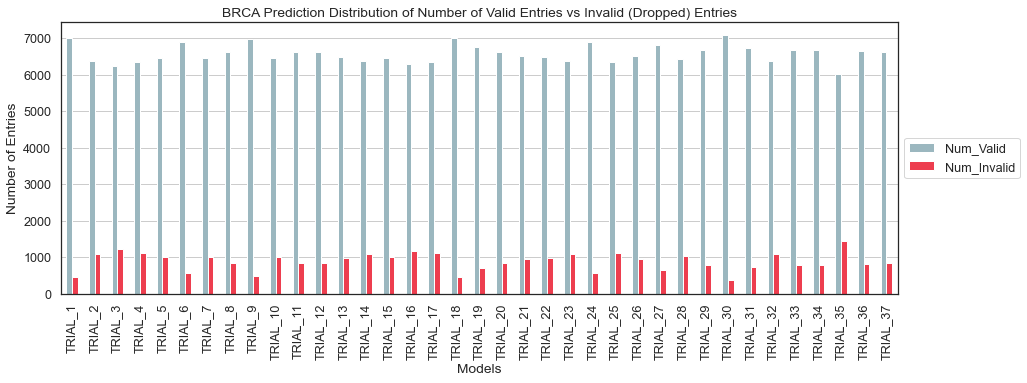

In [92]:
predator.predictions.plot_distribution_valid_vs_invalid("brca")

2021-09-28 01:32:37 | DEBUG    | helpers.helpers_predator.predictions | Plotting number of finalized predictions per model.
Note that following plot shows the unique (protein, mutation, interactor) triplets which had valid prediction.


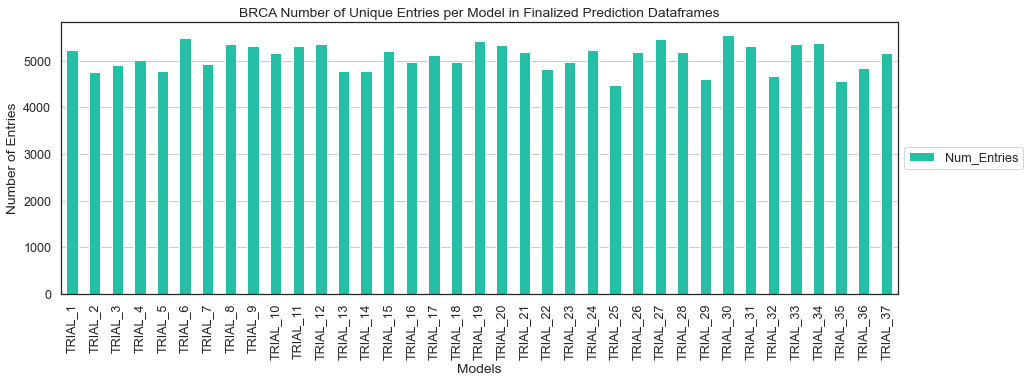

In [93]:
# ????, why goes up to 3500?
predator.predictions.plot_num_finalized_predictions("brca")

In [94]:
predator.predictions['brca_finalized_prediction_dataframes'][0].head()

,Prediction,UniProt_ID,Mutation,Interactor_UniProt_ID
0,0.434282,P28062,R216W,P40306
1,0.538341,Q15842,E237K,Q14654
2,0.512013,Q15842,E237K,P63252
3,0.543550,Q9UKS6,R24H,Q9BY11
4,0.509929,Q9UKS6,R24H,Q9UNF0


In [95]:
predator.prepare_ensemble_prediction_data()

2021-09-28 01:32:38 | INFO     | helpers.helpers_predator.predictions | PredictionsSoft
2021-09-28 01:32:38 | INFO     | helpers.helpers_predator.predictions | Preparing ensemble prediction data for brca taking median ..


  0%|          | 0/37 [00:00<?, ?it/s]

2021-09-28 01:37:49 | DEBUG    | helpers.helpers_predator.predictions | Prediction probabilities data for brca is prepared.
Accessible from `brca_predictions_prob_data`.
2021-09-28 01:37:49 | DEBUG    | helpers.helpers_predator.predictions | Ensemble prediction data for brca is prepared.
Accessible from `brca_ensemble_prediction_data`.
2021-09-28 01:37:49 | DEBUG    | helpers.helpers_predator.predictions | Resulting prediction data is available for brca.
Accessible from predictions.['brca_prediction_results']
2021-09-28 01:37:49 | DEBUG    | helpers.helpers_predator.predictions | Resulting prediction data (no_votes dropped) is available for brca.
Accessible from predictions.['brca_prediction_results_no_votes_dropped']


In [96]:
predator.predictions['brca_predictions_prob_data'].head()

,Trial 0,Trial 1,Trial 2,Trial 3,Trial 4,Trial 5,Trial 6,Trial 7,Trial 8,Trial 9,...,Trial 29,Trial 30,Trial 31,Trial 32,Trial 33,Trial 34,Trial 35,Trial 36,PROB_1s_AVG,VOTED_PREDICTION
0,0.434282,0.29885,0.571602,0.53894,0.88,0.406419,0.145854,0.345603,0.479683,0.617099,...,0.273818,0.26762,0.749085,0.45756,0.492516,0.477967,0.481381,0.329417,0.47282,0
1,0.538341,0.596622,0.604541,0.3387,0.44,0.40567,0.547424,0.606576,0.495839,0.326261,...,0.461963,0.459715,0.150756,0.450595,0.48094,0.358333,0.428704,0.504303,0.48094,0
2,0.512013,0.496622,0.468144,0.273154,0.4,0.399012,0.618258,0.566063,0.483061,0.258612,...,0.436928,0.452293,0.150756,0.447027,0.469733,0.258333,0.518077,0.401226,0.46814,0
3,0.54355,0.408303,0.479241,0.259585,0.4,0.409553,0.301859,0.370816,0.508382,0.303262,...,0.308888,0.381591,0.252196,0.291132,0.485772,0.530123,0.427313,0.311087,0.4,0
4,0.509929,0.270931,0.319456,0.225353,0.42,0.382262,0.372803,0.338909,NO_VOTE,0.249464,...,0.310745,0.318162,0.1,0.304521,NO_VOTE,0.61402,0.389673,0.366978,0.3479,0


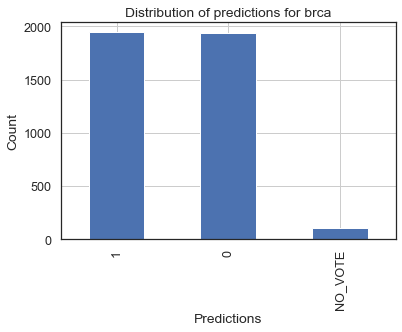

In [97]:
predator.predictions.plot_ensemble_prediction_distribution("brca")

In [98]:
brca_prediction_results_soft = predator.predictions['brca_prediction_results']
brca_prediction_results_soft.head()

,UniProt_ID,Mutation,Interactor_UniProt_ID,Prediction
0,P28062,R216W,P40306,0
1,Q15842,E237K,Q14654,0
2,Q15842,E237K,P63252,0
3,Q9UKS6,R24H,Q9BY11,0
4,Q9UKS6,R24H,Q9UNF0,0


In [99]:
brca_prediction_results_soft_no_votes_dropped = predator.predictions["brca_prediction_results_no_votes_dropped"]
brca_prediction_results_soft_no_votes_dropped.head()

,UniProt_ID,Mutation,Interactor_UniProt_ID,Prediction
0,P28062,R216W,P40306,0
1,Q15842,E237K,Q14654,0
2,Q15842,E237K,P63252,0
3,Q9UKS6,R24H,Q9BY11,0
4,Q9UKS6,R24H,Q9UNF0,0


Label counts:
Disrupting                1934
Increasing + No Effect    1948
Name: Prediction, dtype: int64


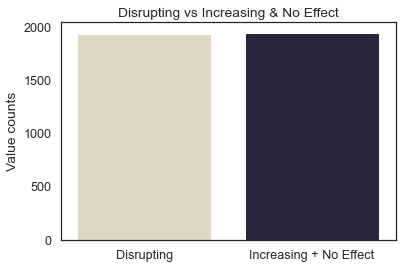

In [100]:
visualize_label_counts(brca_prediction_results_soft_no_votes_dropped, 'Prediction')

In [101]:
brca_ensemble_prediction_data_soft = predator.predictions["brca_ensemble_prediction_data"]

In [102]:
brca_predictions_prob_data_soft = predator.predictions["brca_predictions_prob_data"]

In [103]:
#######
soft_brca_predicted_valid_datasets = predator.predictions[f"brca_predicted_valid_datasets"]
soft_brca_predicted_invalid_datasets = predator.predictions[f"brca_predicted_invalid_datasets"]

## Exporting Model

In [58]:
from helpers.helpers_predator.common import export_serialized_predator

In [59]:
export_serialized_predator(predator)

2021-10-09 19:25:08 | INFO     | helpers.helpers_predator.common | Predator object predator_2021-10-09.pkl is exported.


# loading the model

In [81]:
from helpers.helpers_predator.common import load_predator
from helpers.helpers_predator.common import compare_predator_objects

In [82]:
predator_loaded = load_predator("predator_2021-10-09.pkl")

2021-10-09 20:09:49 | INFO     | helpers.helpers_predator.common | Predator object predator_2021-10-09.pkl is loaded successfully.


In [83]:
compare_predator_objects(predator, predator_loaded)

2021-10-09 20:09:49 | DEBUG    | helpers.helpers_predator.common | Checking attribute n_experiment ..
2021-10-09 20:09:49 | DEBUG    | helpers.helpers_predator.common | Checking attribute n_models ..
2021-10-09 20:09:49 | DEBUG    | helpers.helpers_predator.common | Checking attribute random_seeds ..
2021-10-09 20:09:49 | DEBUG    | helpers.helpers_predator.common | Checking attribute paths ..
2021-10-09 20:09:49 | DEBUG    | helpers.helpers_predator.common | Checking attribute tcga_cohorts ..
2021-10-09 20:09:49 | DEBUG    | helpers.helpers_predator.common | Checking attribute data_materials ..
2021-10-09 20:09:50 | DEBUG    | helpers.helpers_predator.common | Checking attribute default_models ..
2021-10-09 20:09:50 | DEBUG    | helpers.helpers_predator.common | Checking attribute tuned_models ..
2021-10-09 20:09:50 | DEBUG    | helpers.helpers_predator.common | Checking attribute finalized_models ..
2021-10-09 20:09:50 | DEBUG    | helpers.helpers_predator.common | Checking attribute

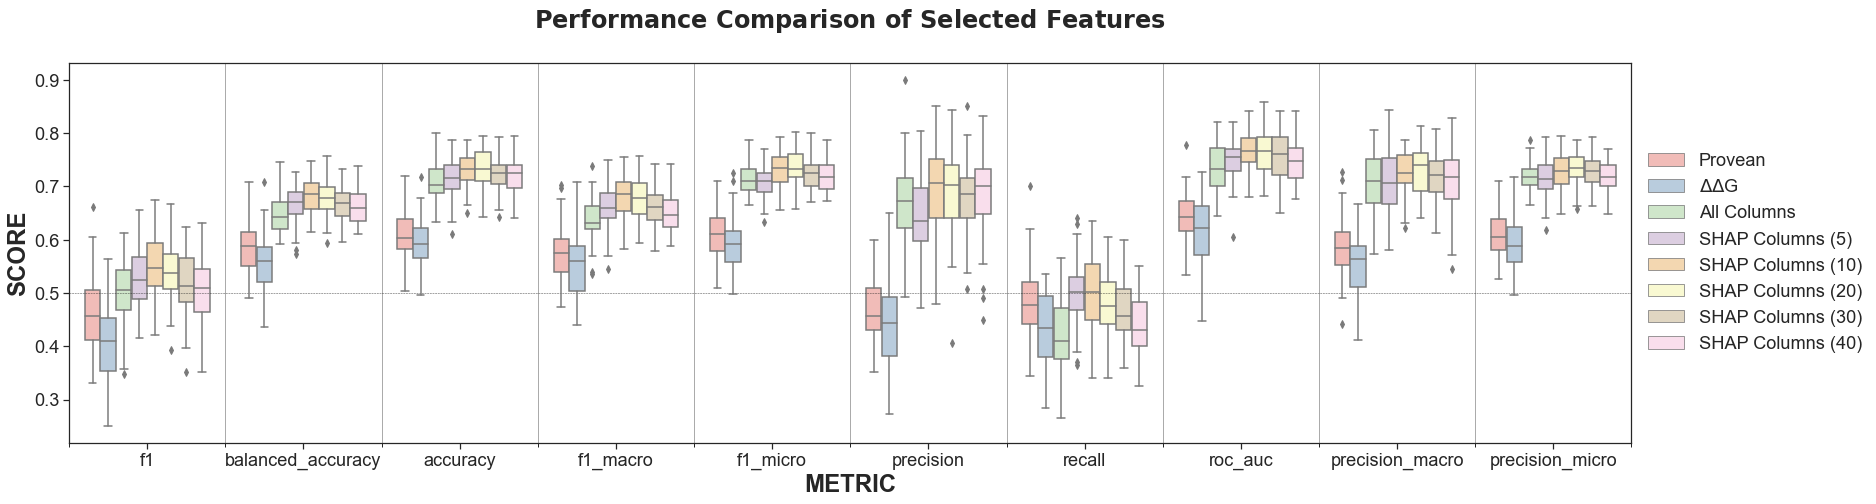

In [79]:
predator.eval_metrics.plot_performance_comparison_results()

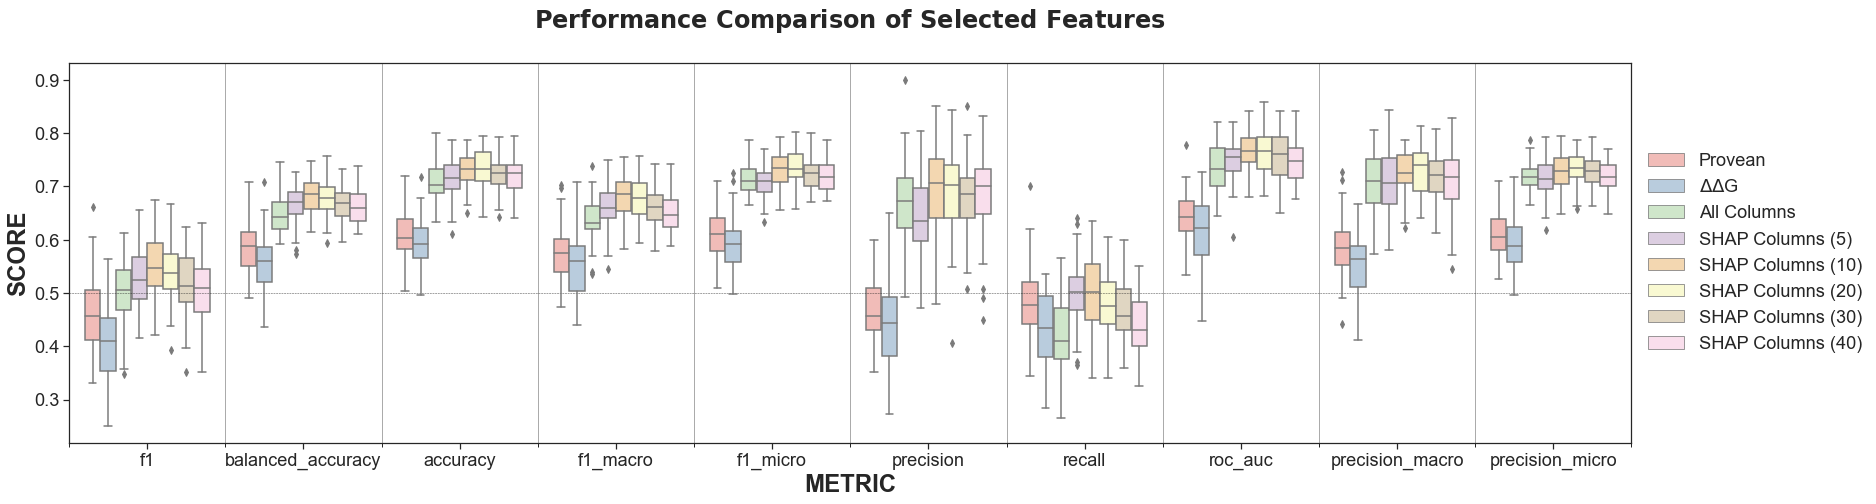

In [80]:
predator_loaded.eval_metrics.plot_performance_comparison_results()

In [125]:
predator.eval_metrics.scoring_metrics_data_melted.equals(
    predator_loaded.eval_metrics.scoring_metrics_data_melted
)

True

In [107]:
predator.data_materials.__dict__.keys()

dict_keys(['n_experiment', 'random_seeds'])

In [110]:
predator.data_materials.keys()

dict_keys(['train_data', 'train_data_processed', 'sampled_train_data_list', 'prepared_dataframes', 'label_proportions_dataframes', 'Xs', 'ys', 'Xs_train', 'ys_train', 'Xs_valid', 'ys_valid', 'Xs_train_random', 'ys_train_random', 'Xs_valid_random', 'ys_valid_random', 'Xs_shap_5', 'Xs_train_shap_5', 'Xs_valid_shap_5', 'Xs_provean', 'Xs_train_provean', 'Xs_ddG', 'Xs_train_ddG', 'Xs_shap_10', 'Xs_train_shap_10', 'Xs_valid_shap_10', 'Xs_shap_20', 'Xs_train_shap_20', 'Xs_valid_shap_20', 'Xs_shap_30', 'Xs_train_shap_30', 'Xs_valid_shap_30', 'Xs_shap_40', 'Xs_train_shap_40', 'Xs_valid_shap_40'])

In [108]:
predator_loaded.data_materials.__dict__.keys()

dict_keys(['n_experiment', 'random_seeds'])

In [111]:
predator_loaded.data_materials.keys()

dict_keys(['train_data', 'train_data_processed', 'sampled_train_data_list', 'prepared_dataframes', 'label_proportions_dataframes', 'Xs', 'ys', 'Xs_train', 'ys_train', 'Xs_valid', 'ys_valid', 'Xs_train_random', 'ys_train_random', 'Xs_valid_random', 'ys_valid_random', 'Xs_shap_5', 'Xs_train_shap_5', 'Xs_valid_shap_5', 'Xs_provean', 'Xs_train_provean', 'Xs_ddG', 'Xs_train_ddG', 'Xs_shap_10', 'Xs_train_shap_10', 'Xs_valid_shap_10', 'Xs_shap_20', 'Xs_train_shap_20', 'Xs_valid_shap_20', 'Xs_shap_30', 'Xs_train_shap_30', 'Xs_valid_shap_30', 'Xs_shap_40', 'Xs_train_shap_40', 'Xs_valid_shap_40'])

In [102]:
getattr(predator, "n_experiment")

50

In [103]:
getattr(predator_loaded, "n_experiment")

50

In [86]:
predator_loaded.__dict__.keys()

dict_keys(['n_experiment', 'n_models', 'random_seeds', 'paths', 'tcga_cohorts', 'data_materials', 'default_models', 'tuned_models', 'finalized_models', 'qualified_models', 'eval_valid', 'determined_feature_set', 'determined_features', 'shap_feature_selector', 'eval_metrics', 'fine_tuner', 'ensemble_voting_classifier', 'predictions', 'eliminate_models', 'config'])

In [79]:
predator_loaded.config == predator.config

True

In [126]:
DATA_FOLDER_PATH = "../data/predictions_datasets/"

In [128]:
predator.export_prediction(
    tcga="brca",
    data=brca_prediction_results,
    file_name="predictions",
    folder_path=DATA_FOLDER_PATH,
    voting="soft",
    overwrite=False,
    file_extension='csv'
)

2021-09-28 01:56:12 | DEBUG    | helpers.helpers_predator.common | Results folder with ID acf35ed1 is created.
2021-09-28 01:56:12 | DEBUG    | helpers.helpers_predator.common | Exporting data predictions at location ../data/predictions_datasets/ in folder brca_prediction_2021-09-28\acf35ed1..
2021-09-28 01:56:12 | INFO     | helpers.helpers_predator.common | ../data/predictions_datasets/brca_prediction_2021-09-28\acf35ed1\predictions_soft_2021-09-28.csv is exported successfully.
2021-09-28 01:56:12 | DEBUG    | helpers.helpers_predator.common | Config is exported.


# The End

**Later**

Maybe as number of experiment goes to positive infinity, the class 0 and class 1 distribution gets equals. 

After looking at ROC Curves, we can decide to assign class 0 if we are very confident, i.e. prediction probability above some
threshold, rather than 0.50